In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta

import pymc as pm
import arviz as az

# Problem 1

In [3]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    sample = np.random.binomial(n, p)   # Take sample of n with probability p
    ps = np.linspace(0, 1, 100)    # For all probabilities between 0 and 1
    pmf = ps**(sample) * (1-ps)**(n - sample)
    numerator = 1 * pmf   # Unfiform prior has pmf 1
    denominator = np.sum(pmf) * 1 / 100  # Approximation of Integral
    posterior = numerator / denominator   # Find the posterior

    # Plot the posterior distribution
    plt.plot(ps, posterior)
    plt.title("Posterior Distribution of p with uniform prior")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.show()
    return ps[np.argmax(posterior)]   # Return the MAP

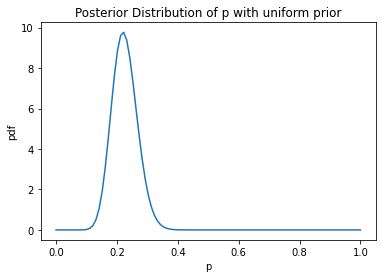

0.22222222222222224


In [4]:
print(bernoulli_sampling(0.2, 100))

# Problem 2

In [5]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    sample = np.random.binomial(n, p)   # Take sample of n with probability p
    ps = np.linspace(0, 1, 100)    # For all probabilities between 0 and 1
    pmf = ps**(sample) * (1-ps)**(n - sample)
    numerator = prior.pdf(ps) * pmf   # Multiply by prior
    denominator = np.sum(numerator) * 1/100 # Approximation of Integral
    posterior = numerator / denominator   # Find the posterior

    # Plot the posterior distribution
    plt.plot(ps, posterior, label="posterior")
    plt.plot(ps, prior.pdf(ps), label="prior")
    plt.title("Distribution of p with other prior")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.legend()
    plt.show()
    return ps[np.argmax(posterior)]    # Return the MAP

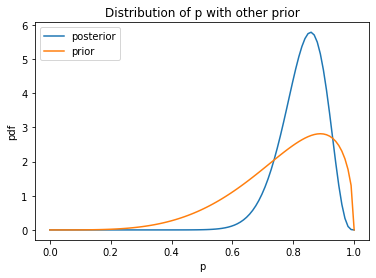

MAP: 0.8585858585858587
With p=0.9


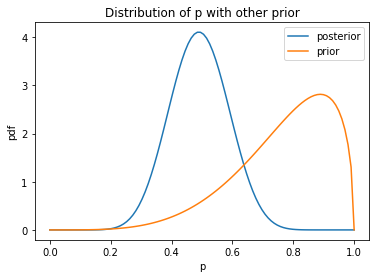

MAP: 0.48484848484848486
With p=0.4


In [6]:
print("MAP:", non_uniform_prior(0.9, 20, beta(5, 1.5)))
print("With p=0.9")
print("MAP:", non_uniform_prior(0.4, 20, beta(5, 1.5)))
print("With p=0.4")

# Problem 3

In [7]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. Return a list of strings, not including the 0th day.
    """
    state = 0   # Assume that the initial state is 0
    labels = {0: "sunny", 1: "rain", 2: "wind"}
    forecast = []
    for day in range(days):
        state = np.random.choice(3, 1, p=transition_matrix[state])[0]  # find the next state
        forecast.append(labels[int(state)])     # Add to forecast
    return forecast

In [8]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

In [9]:
print(weather_forecast(transition_matrix, days=10))

['wind', 'wind', 'rain', 'wind', 'sunny', 'sunny', 'wind', 'rain', 'rain', 'wind']


# Problem 4

In [20]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC model for this situation and sample from the 
    poterior n times. Plot the trace plot and return the expected value of
    the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (expected value of p)
    """
    with pm.Model() as model:
        p = pm.Beta('p', alpha=1, beta=1)  # Define the prior
        y = pm.Bernoulli('y', p=p, observed=data)  # Define likelihood to be distributed as Bernoulli
        trace = pm.sample(n)   # Sample from the posterior
        az.plot_trace(trace)    # Plot the posterior
        new_p = trace.posterior['p']
        mean = float(new_p.mean())   # Expected value
        return mean

In [21]:
data = bernoulli.rvs(0.2, size=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Expected Value 0.17575121386466275


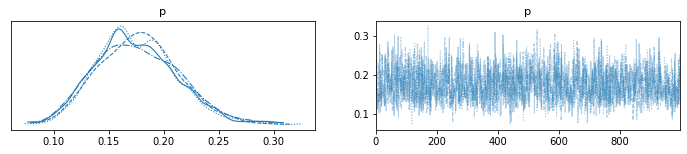

In [22]:
expected_value = posterior_sampling(data)
print("Expected Value", expected_value)

# Problem 5

In [17]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):
    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu, 1/tau) where mu has a prior of Normal(m, s), 
    and tau has a prior of Gamma(alpha, beta). Set up a PyMC model for this 
    situation and sample from the posterior n times. Plot the trace plots for 
    mu and tau, and return the expected value of the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    with pm.Model() as model:
        mu = pm.Normal('mu', mu=m, sigma=s)  # Define the prior of mu
        T = pm.Gamma("gamma", alpha=alpha, beta=beta)
        y = pm.Normal('y', mu=mu, sigma=1/T, observed = observed_heights)  # Define likelihood to be distributed as Bernoulli
        trace = pm.sample(n)   # Sample from the posterior
        az.plot_trace(trace)    # Plot the posterior
        new_mu = trace.posterior['mu']
        new_gamma = trace.posterior['gamma']
        mean = float(new_mu.mean())   # Expected value
        return mean

In [18]:
heights = np.random.normal(180,10,100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, gamma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Expected Value of mu: 179.11731555986785


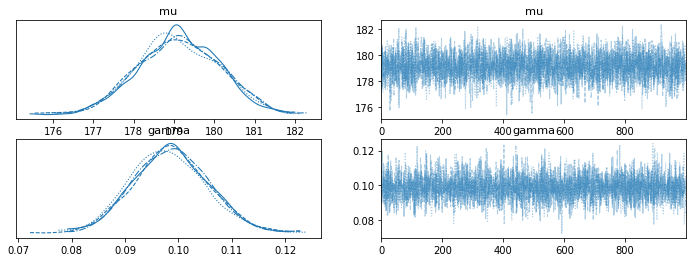

In [19]:
expected_value = height_model(heights)
print("Expected Value of mu:", expected_value)